<h1>Transfer Learning with BERT</h1>

In [1]:
!nvidia-smi # check colab allocated GPU

Tue Mar 31 17:33:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# References
# https://colab.research.google.com/drive/1IubZ3T7gqD09ZIVmJapiB5MXUnVGlzwH#scrollTo=7LbVjtktg3Ln
# https://medium.com/analytics-vidhya/bert-in-keras-tensorflow-2-0-using-tfhub-huggingface-81c08c5f81d8
# https://medium.com/@brn.pistone/bert-fine-tuning-for-tensorflow-2-0-with-keras-api-9913fc1348f6

# Requirements
!pip install sentencepiece
!pip install bert-for-tf2

%tensorflow_version 2.1
from __future__ import absolute_import, division, print_function, unicode_literals
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import bert
import os
import math
import numpy as np
import random
import re
from datetime import datetime
from tensorflow.keras.layers import Lambda, Conv1D, Dense, Flatten, Dropout,Embedding, LSTM, Bidirectional, Input, Dropout, GlobalAveragePooling1D, AveragePooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
import bert
from bert import bert_tokenization 

print('Libraries loaded')


     |████████████████████████████████| 1.0MB 3.4MB/s 
     |████████████████████████████████| 40kB 2.8MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.13.5-cp36-none-any.whl size=29948 sha256=8e2bde00850603f343483dc21f9a8c36d96512834cc542cd64b458a13574c84d
  Stored in directory: /root/.cache/pip/wheels/ed/11/48/86aff8a0442aa4728c921027a4100ac28878e9d977e76e2d52
  Created wheel for py-params: filename=py_params-0.8.3-cp36-none-any.whl size=4690 sha256=cd88c0e3f7f1125d401fcdc4a85c691cd3444987425a79ef694b47a98c45b82e
  Stored in directory: /root/.cache/pip/wheels/1a/98/f8/502fc6b5a7c969276f611efeef0d074c871092d38672203b27
  Created wheel for params-flow: filename=params_flow-0.7.4-cp36-none-any.whl size=16195 sha256=f81ad25bd03108bcdbe7e2a5b596c7d757d646b0fda3bab6130d133d55dabd2e
  Stored in directory: /root/.cache/pip/wheels/86/30/40/507b60d68b67ac87f35e95c98f5b296a32f146d5ae1d1d5aa7
Successfully built bert-for-tf2 py-params params-flow
`%tensorflow_version` only switches

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
!ls "/content/drive/My Drive/Colab"

agr_en_train.csv		  BERT.ipynb   datagen.py   Results
Bert-finetuning-54.ipynb	  conv_mod.py  Models	    StyleGAN2.ipynb
Bert-FineTuning-F1Score-58.ipynb  data	       __pycache__  Untitled0.ipynb


<h2>Settings</h2>

In [5]:
CLASSES = ['CAG', 'NAG', 'OAG']
MAX_LENGTH = 128
RETRAIN_BERT = True
TRAIN_SAMPLES = 0.8
DATA_FILE = '/content/drive/My Drive/Colab/agr_en_train.csv'
print('Settings set')

Settings set


<h2>Load BERT Model from Tensorflow HUB</h2>

In [6]:
bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(bert_path,trainable=True)
print('Model Loaded')

vocab_file1 = bert_layer.resolved_object.vocab_file.asset_path.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file1, do_lower_case=True)
print('Tokenizer Created')

print('Sample Tokenizer Operations')
sample_x = tokenizer.tokenize('this is a sample tokening operation. It spans multiple sentences')
sample_ids = tokenizer.convert_tokens_to_ids(sample_x)
print(sample_x)
print(sample_ids)

Model Loaded
Tokenizer Created
Sample Tokenizer Operations
['this', 'is', 'a', 'sample', 'token', '##ing', 'operation', '.', 'it', 'spans', 'multiple', 'sentences']
[2023, 2003, 1037, 7099, 19204, 2075, 3169, 1012, 2009, 14798, 3674, 11746]


<h1>Data Loading and Cleaning</h1>
<p>Some preprocessing steps are applied to the data after it is loaded</p>
<ul>
<li>punctuation is removed</li>
<li>line breaks and double spaces are replaces with single space</li>
<li>text is all lower-cased</li>
<li>Emojis, symbols, flags and pictographs are removed from samples</li>
<li>some slang is replaced with the correct english words</li>
<li>URLs are removed from the samples</li>
</ul>

Wordcount distribution


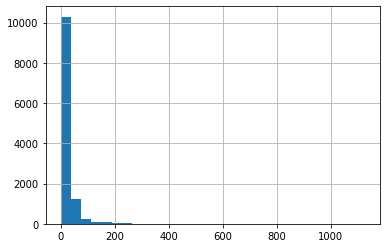

Label distribution


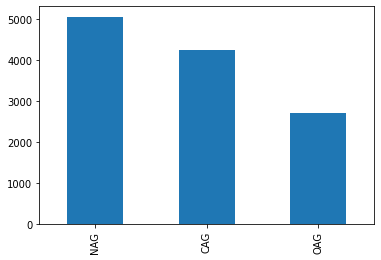

English distribution


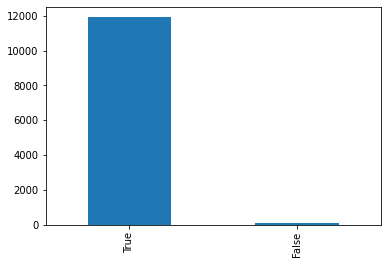

                                                   Text  ... isEnglish
41                   modi ji all the pain  nö real gain  ...     False
314   yàar my ears are bleeding stop this  get the b...  ...     False
813            रजनथ सह फर कहग क हम ननद करत ह डब मर सरकर  ...     False
830    bot powered by prince fadii  just now done  i...  ...     False
1107   bot powered by ishaq zada  see my bot speed  ...  ...     False
1441       live  nse स pehlakadam season 2 grand finale  ...     False
1462  what you should know about turkeys president r...  ...     False
1621   bot powered by prince fadii  see my bot speed...  ...     False
1704  a question of order india turkey and the retur...  ...     False
1719  अर कछ त कर खल हजड क तरह तल बजत रहन स कछ नह हग ...  ...     False

[10 rows x 4 columns]


In [7]:
def remove_URL(s):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", s)

def remove_punctuation(s):
    return re.sub(r'[^\w\s]', '', s)
    
def remove_Emoji(s):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', s)

def replace_chars(Data):
    Data['Text'] = Data['Text'].str.replace('\n',' ')
    Data['Text'] = Data['Text'].str.replace('  ',' ')
    Data['Text'] = Data['Text'].str.strip()
    Data['Text'] = Data['Text'].str.lower()
    Data['Text'] = Data['Text'].str.replace('pls','please')
    Data['Text'] = Data['Text'].str.replace('plz','please')
    Data['Text'] = Data['Text'].str.replace(' u ',' you ')
    Data['Text'] = Data['Text'].str.replace(' ur ',' your ')
    Data['Text'] = Data['Text'].str.replace(' vs ',' versus ')
    Data['Text'] = Data['Text'].str.replace(' tks ',' thanks ')
    Data['Text'] = Data['Text'].str.replace(' tkz ',' thanks ')
    Data['Text'] = Data['Text'].str.replace(' cud ',' could ')
    Data['Text'] = Data['Text'].str.replace(' b ',' be ')
    Data['Text'] = Data['Text'].str.replace(' r ',' are ')
    Data['Text'] = Data['Text'].str.replace(' gonna ',' going to ')
    Data['Text'] = Data['Text'].str.replace(' y ',' why ')
    Data['Text'] = Data['Text'].str.replace('bn ',' billion ')
    Data['Text'] = Data['Text'].str.replace('tn ',' trillion ')
    Data['Text'] = Data['Text'].str.replace('£',' pounds ')
    Data['Text'] = Data['Text'].str.replace('$',' dollars ')
    return Data

def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

def create_data_frame():
    data = pd.read_csv(DATA_FILE)
    data.columns = ['ID','Text','Indicator']
    data.drop(['ID'], axis='columns', inplace = True)
    
    data = replace_chars(data)
    data['Text'] = data['Text'].apply(remove_Emoji)
    data['Text'] = data['Text'].apply(remove_URL)
    data['Text'] = data['Text'].apply(remove_punctuation)
    data['Length'] = data['Text'].str.split(' ').apply(len)
    data['isEnglish'] = data['Text'].apply(isEnglish)
    return data

data = create_data_frame()
print('Wordcount distribution')
data['Length'].hist(bins=30)
plt.show()
print('Label distribution')
data['Indicator'].value_counts().plot(kind='bar')
plt.show()
print('English distribution')
data['isEnglish'].value_counts().plot(kind='bar')
plt.show()
print(data[data['isEnglish']==False][0:10])


<p>Samples were identified with non-english characters in the dataset, however these weren't removed as most of them included English words and so could contribute to the training. </p>

<h2>Data Processing</h2>
<p>The Bert model loaded from TF Hub expects input data in a particular format. For every text sample, three arrays are created: most importantly the sample is tokenised and then converted to Ids using BERTs tokenizer dictionary. An input mask array and sentence location (not used for classification) array are also created.

In [8]:
def Bertify(Set):
    
    tokens = map(tokenizer.tokenize, Set)
    tokens = map(lambda tok: tok[:MAX_LENGTH-2], tokens)
    tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], tokens)
    
    token_ids = map(tokenizer.convert_tokens_to_ids, tokens)
    token_ids = map(lambda tids: tids + [0] * (MAX_LENGTH - len(tids)), token_ids)
    # token_ids = map(lambda tids: np.array(tids), token_ids)
    token_ids = list(token_ids)
    token_masks =[]
    sent_segs = []
    for token_list in token_ids:
        token_masks.append([1 if x > 0 else 0 for x in token_list])
        sent_segs.append([0 for x in token_list])    
    return  [tf.cast(token_ids,tf.int32), tf.cast(sent_segs,tf.int32), tf.cast(token_masks,tf.int32)]

def preprocess_data(data): 
    #One hot encoding
    label_encoder = LabelEncoder()
    label_encoder = label_encoder.fit(CLASSES)
    label_ints = label_encoder.transform(data.values[:,1])
    label_ints = label_ints.reshape(len(label_ints), 1)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    label_onehot = onehot_encoder.fit_transform(label_ints)
    
    #Split to training and test
    train_len = int(len(data.index) * TRAIN_SAMPLES)
    
    train_set = data.values[:train_len,0]
    train_features = Bertify(train_set)
    train_labels = np.array(label_onehot[:train_len,:])
    
    test_set = data.values[train_len:,0]
    test_features = Bertify(test_set)
    test_labels = np.array(label_onehot[train_len:,:])
    
    return train_features, train_labels, test_features, test_labels


train_tokens, train_labels, test_tokens, test_labels = preprocess_data(data)
print('Training data loaded')
print(train_tokens[0:10])
print(train_labels[0:10])

Training data loaded
[<tf.Tensor: shape=(9598, 128), dtype=int32, numpy=
array([[ 101, 2087, 1997, ...,    0,    0,    0],
       [ 101, 2085, 3160, ...,    0,    0,    0],
       [ 101, 4501, 2003, ...,    0,    0,    0],
       ...,
       [ 101, 3531, 2425, ...,    0,    0,    0],
       [ 101, 2054, 2052, ...,    0,    0,    0],
       [ 101, 2307,  102, ...,    0,    0,    0]], dtype=int32)>, <tf.Tensor: shape=(9598, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, <tf.Tensor: shape=(9598, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>]
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0

<h2>Model Definition</h2>
<p>The recommended way to use BERT is via fine-tuning with minimal additional layers appended on to focus results to the task at hand.
The example on tensorlow site uses the following layers: a lambda to flatten output, dropout, dense layer, dropout and a softmax dense layer to compute categorical output. https://github.com/kpe/bert-for-tf2/blob/master/examples/gpu_movie_reviews.ipynb</p>
<p>BERT Paper recommends learning rates of 5e-5, 3e-5 or 2e-5 with an Adam optimizer. I chose the smallest of these 2e-5</p>


In [9]:
METRICS = [
      tf.keras.metrics.CategoricalCrossentropy(name='categoricalcrossentropy'),
      tf.keras.metrics.CategoricalAccuracy(name='categoricalaccuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

def build_model_fullyconnected():
    """add pretrained bert model as a keras layer"""
    input_word_ids = Input((MAX_LENGTH,), dtype=tf.int32, name='input_token_ids')
    input_masks = Input((MAX_LENGTH,), dtype=tf.int32, name='input_token_masks')
    input_segments = Input((MAX_LENGTH,), dtype=tf.int32, name='input_sent_segms')
    
    if not RETRAIN_BERT:
        bert_layer.trainable = False
    
    _, sout = bert_layer([input_word_ids, input_masks, input_segments])
    X = Lambda(lambda seq: seq[:, 0, :])(sout)
    X = Dropout(0.35)(X)
    X = Dense(768, activation="relu")(X)
    X = Dropout(0.35)(X)
    output_ = Dense(3, activation=tf.nn.softmax)(X)

    #model = Model(input_,output_)
    model = Model([input_word_ids, input_masks, input_segments],output_)
    adam = Adam(learning_rate=0.2e-5, beta_1=0.9, beta_2=0.999, amsgrad=False) 
    model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics = METRICS)
    return model

model = build_model_fullyconnected()
print(model.summary())
print('done')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token_ids (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_token_masks (InputLayer)  [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_sent_segms (InputLayer)   [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_token_ids[0][0]            
                                                                 input_token_masks[0][0]      

<h2>Model Training</h2>

<p>BERT Paper recommends batch sizes of 16 or 32, with number of epochs of 2, 3 or 4. I use a batch size of 32 and was achieving better f1 scores with significantly more epochs. In the end I achieved the best validation score with around 10</p>

In [10]:
def fitModel(Model, training_set, training_label, testing_set, testing_label):
    checkpointName = os.path.join('Model', "bert_faq.ckpt")

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointName,
                                                     save_weights_only=True,
                                                     save_freq = 25000,
                                                     mode='auto',
                                                     verbose=1)
    # callback = StopTrainingClassComplete()
    history = Model.fit(
        training_set,
        training_label,
        epochs=30,
        batch_size=32,
        validation_split=0.25,
        verbose=1,
        callbacks=[cp_callback,
                   callbacks.EarlyStopping(monitor='val_loss', min_delta=0,patience=15, restore_best_weights=True)]
    )
    return history

history = fitModel(model, train_tokens, train_labels, test_tokens, test_labels)

Epoch 1/30
225/225 [==============================] - 114s 508ms/step - loss: 1.1036 - categoricalcrossentropy: 1.1036 - categoricalaccuracy: 0.4041 - precision: 0.4291 - recall: 0.1568 - auc: 0.5859 - val_loss: 1.0389 - val_categoricalcrossentropy: 1.0389 - val_categoricalaccuracy: 0.4533 - val_precision: 0.5919 - val_recall: 0.1758 - val_auc: 0.6474
Epoch 2/30
225/225 [==============================] - 112s 499ms/step - loss: 1.0360 - categoricalcrossentropy: 1.0361 - categoricalaccuracy: 0.4553 - precision: 0.5255 - recall: 0.2176 - auc: 0.6485 - val_loss: 0.9555 - val_categoricalcrossentropy: 0.9555 - val_categoricalaccuracy: 0.5108 - val_precision: 0.6839 - val_recall: 0.2317 - val_auc: 0.7182
Epoch 3/30
225/225 [==============================] - 112s 499ms/step - loss: 0.9690 - categoricalcrossentropy: 0.9690 - categoricalaccuracy: 0.5118 - precision: 0.5824 - recall: 0.3212 - auc: 0.7101 - val_loss: 0.9209 - val_categoricalcrossentropy: 0.9209 - val_categoricalaccuracy: 0.5337 -

<h2>Training Metrics</h2>

<h3>Categorical Cross Entropy</h3>
<p></p>

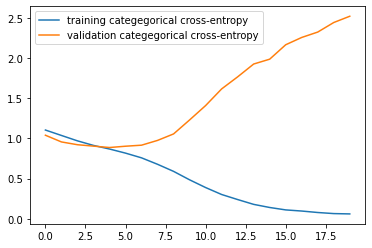

In [15]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(history.history['categoricalcrossentropy'], label = 'training categegorical cross-entropy')
ax.plot(history.history['val_categoricalcrossentropy'], label = 'validation categegorical cross-entropy')
ax.legend()
plt.show()

<h3>Precision</h3>
<p></p>

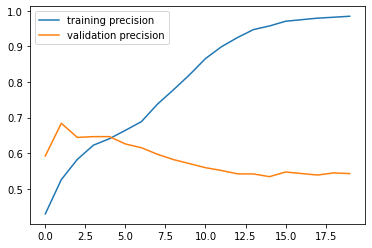

In [12]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(history.history['precision'], label = 'training precision')
ax.plot(history.history['val_precision'], label = 'validation precision')
ax.legend()
plt.show()

<h3>Recall</h3>
<p></p>

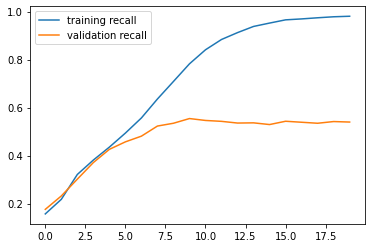

In [13]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(history.history['recall'], label = 'training recall')
ax.plot(history.history['val_recall'], label = 'validation recall')
ax.legend()
plt.show()

<h2>Evaluation</h2>

In [14]:
# Baseline - Random predictions
identity = np.eye(len(CLASSES))
baseline_labels=identity[np.random.choice(len(CLASSES), len(test_labels))]
print('done generating random predictions')

# Model Predictions
y_pred = model.predict(test_tokens)
print('done generating test predictions')

print('Classification Report - Baseline')
report_baseline = metrics.classification_report(test_labels.argmax(axis=1),
                                       baseline_labels.argmax(axis=1),
                                      target_names = CLASSES)
print(report_baseline)
print('Classification Report - Model')
report_model = metrics.classification_report(test_labels.argmax(axis=1),
                                       y_pred.argmax(axis=1),
                                      target_names = CLASSES)
print(report_model)

print('Confusion Matrix')
matrix = metrics.confusion_matrix(test_labels.argmax(axis=1), y_pred.argmax(axis=1))
print(CLASSES)
print(matrix)

done generating random predictions
done generating test predictions
Classification Report - Baseline
              precision    recall  f1-score   support

         CAG       0.33      0.32      0.33       817
         NAG       0.41      0.33      0.37      1041
         OAG       0.22      0.32      0.26       542

    accuracy                           0.32      2400
   macro avg       0.32      0.32      0.32      2400
weighted avg       0.34      0.32      0.33      2400

Classification Report - Model
              precision    recall  f1-score   support

         CAG       0.47      0.58      0.52       817
         NAG       0.70      0.69      0.70      1041
         OAG       0.57      0.37      0.45       542

    accuracy                           0.58      2400
   macro avg       0.58      0.55      0.55      2400
weighted avg       0.59      0.58      0.58      2400

Confusion Matrix
['CAG', 'NAG', 'OAG']
[[475 228 114]
 [281 721  39]
 [265  78 199]]
